In [ ]:
# Install konlpy
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Embedding, Conv1D, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import SpatialDropout1D, Reshape, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import gensim
from gensim.models import word2vec
from konlpy.tag import Kkma, Komoran, Okt, Hannanum

import re

# 데이터 준비하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # 원하는 세부 경로로 변경이 불가능합니다.

Mounted at /content/drive


In [ ]:
# TSV 파일 불러오기
data_dir = '/content/drive/MyDrive/data/'
train = pd.read_csv(data_dir + 'train.tsv', sep='\t')
test = pd.read_csv(data_dir + 'dev.tsv', sep='\t')

In [ ]:
train.head()

,comments,contain_gender_bias,bias,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate


In [ ]:
train.isna().sum(), test.isna().sum()

(comments               0
 contain_gender_bias    0
 bias                   0
 hate                   0
 dtype: int64,
 comments               0
 contain_gender_bias    0
 bias                   0
 hate                   0
 dtype: int64)

In [ ]:
# 라벨 데이터 확인 - 다중 분류 문제
train['hate'].value_counts()/len(train)

none         0.441489
offensive    0.316489
hate         0.242021
Name: hate, dtype: float64

In [ ]:
# train 과 test 라벨 데이터 분포 비교 (비슷함 확인)
test['hate'].value_counts()/len(test)

offensive    0.401274
none         0.339703
hate         0.259023
Name: hate, dtype: float64

In [ ]:
train.shape, test.shape

((7896, 4), (471, 4))

In [ ]:
train = train[['comments','hate']]
test = test[['comments','hate']]

# 타겟변수 인코딩 (라벨-원핫 인코딩)

In [ ]:
# LabelEncoder를 사용하여 문자열 레이블을 정수로 변환
label_encoder = LabelEncoder()
train['label_encoded'] = label_encoder.fit_transform(train['hate'])

# # OneHotEncoder를 사용하여 원-핫 인코딩 : loss : sparse 삭제
# onehot_encoder = OneHotEncoder(sparse=False)
# onehot_encoded = onehot_encoder.fit_transform(train[['label_encoded']])

# train_label = utils.to_categorical(train_label) # 0 or 1 -> one-hot vector
# test_label = utils.to_categorical(test_label) # 0 or 1 -> one-hot vector

# # 결과 확인
# # train['label_encoded'] = train['label_encoded'].astype(str)  # 정수를 문자열로 변환 (선택적)
# train['onehot_encoded'] = list(map(lambda x: list(map(int, x)), onehot_encoded))
print(train)

                                               comments  hate  label_encoded
0     (현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...  hate              0
1     ....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...  none              1
2     ...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...  hate              0
3                    1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데  none              1
4     1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...  hate              0
...                                                 ...   ...            ...
7891                                      힘내세요~ 응원합니다!!  none              1
7892                             힘내세요~~삼가 고인의 명복을 빕니다..  none              1
7893                              힘내세용 ^^ 항상 응원합니닷 ^^ !  none              1
7894  힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...  none              1
7895                                 힘들면 관뒀어야지 그게 현명한거다  none              1

[7896 rows x 3 columns]


<ipython-input-13-0d89f2f6095c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label_encoded'] = label_encoder.fit_transform(train['hate'])


# 한국어 전처리

In [ ]:
def morphs_cleaning(column):
    '''
    1. 함수 설명 : input으로 넣은 열을 토큰화하고 불용어 제거, 숫자 및 구두점 제거 문자만 추출, 클렌징 작업을 마친 문장을 리스트로 반환하는 함수
    2. Args :
        column   (Series) : 클렌징하고 싶은 열 이름
    3. Return :
        cleaned_list (List) : 클렌징 작업을 마친 리스트 형태의 데이터
    '''

    okt = Okt()

    cleaned_list = [] # 클렌징된 본문 내용
    # 감정분석이므로 중립적인 단어만 빼자
    stopwords = ['하다','있다','같다','너무','되다','그렇다','돼다','나다','때문','스럽다','지금','우리','되어다','이렇다'
                 ,'하나','이다','대해','위해','자기','그렇게','수가','두다','진짜','정도','이렇게','내다','이지','말다'
                 ,'내','들','것','나','수','게','거','다','때','이','적','그','응','난','걸','건','곳','후','님','데','중','만'
                 , '좀', '한', '니', '하', '더', '뭐', '애', '저', '지다', '하', '너', '해', '네', '기', '아', '도', '전','알'
                 , '자', '대', '함', '듯', '두', '줄','임','살','분','남','지','머','원','보다','대다','제','연','성','문','앞'
                 , '가','은','에','는','을','의','를','로','으로','고','에서','하고','들다','가다','인데','주','구','번'
                 ,'인','라','면','랑','까지','야','한테','냐','요','이나','차다','이나','치','리다','과','서','부터'
                 ,'해주다','싶다','이랑','이네','처럼','와','여','비','라고','이라','에게','이냐','해보다','이야','이고','이라고'
                 ,'인가','이다','녀','명','눈','세','서다','사','찌','시','위','상','기','니까','엔','에는','그','저','처','조'
                 ,'래','라는','모','물','보','식','든','단','에도','이번','이기','젠','몇','질','이라는','바','재','감','얼','양'
                 ,'작','백','죠','이니','솔','인거','밖에','지만','어','라면','이래','그거','저거','이거','씩','박'
                ]
    for idx in range(len(column)):
        #- 토큰화, 품사 태깅
        # stem은 아름다운-> 아름답다
        # norm ~하게 -> 하다
        raw_morphs_tagged = okt.morphs(column[idx], norm=True, stem=True)

        # 불용어 제거
        word_cleaned = []
        for word in raw_morphs_tagged: #  ('서울', 'Noun'), ('인천', 'Noun')
            # Foreign == ”, “ 와 같이 제외되어야할 항목들
            # & 한 글자로 이뤄진 단어들을 제외 & 원치 않는 단어들을 제외
            # 특수 기호에 해당하지 않을 경우

            if (word not in stopwords) and re.match('^[a-zA-Z가-힣]+', word):
                word_cleaned.append(word)

        word_cleaned = ' '.join(word_cleaned)
        cleaned_list.append(word_cleaned)


    return cleaned_list


In [ ]:
# 전처리된 열과 사용빈도를 확인하기
cleaned_list = morphs_cleaning(train['comments'])

In [ ]:
print(train['comments'][:3])

0    (현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...
1    ....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...
2    ...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...
Name: comments, dtype: object


In [ ]:
cleaned_list[:3]

['현재 호텔 주인 심정 마른하늘 날벼락 맞다 호텔 망하다 생기다 누 군 계속 추모 받다',
 '한국 미인 대표 너무나 곱 아름답다 모습 모습 뒤 슬픔 미처 알다',
 '못 넘다 고통 즐기다 넘다 마땅하다 처벌 받다 래야 공정하다 사회 심다 거두다']

In [ ]:
# 전처리한 결과를 텍스트 파일로 저장
result_file = 'korean_hate_speech.txt'       # 텍스트 파일임!
with open(result_file, 'wt', encoding='utf-8') as myfile:
     myfile.write('\n'.join(cleaned_list))           # 라인으로 결합

print(result_file + ' 파일 저장됨!')

korean_hate_speech.txt 파일 저장됨!


# 토큰화 및 사전 만들기

In [ ]:
# Okt 객체 생성
okt = Okt()
# 각 문서에 대해 Okt를 사용하여 토큰화
tokenized_documents = [okt.morphs(sentence) for sentence in cleaned_list]
# Tokenizer 객체 생성 및 단어 인덱스 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_documents)
input_sequences = tokenizer.texts_to_sequences(cleaned_list)
word_index = tokenizer.word_index
max_vocab_size = 150000
vocab_size = min(max_vocab_size, len(word_index) + 1)
vocab_size

11730

In [62]:
# PBL3 참조
max_len = 72
padded_sequences = pad_sequences(input_sequences, maxlen=max_len)
padded_sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0, 1181, 1304, 2565, 1877, 5965, 4171,   40, 1304,
        160,  792,  697,  149, 1878,   30], dtype=int32)

# Word2Vec 임베딩하기

In [ ]:
# 지난 번에 만든 word2vec 모델 불러오기
model_dir = '/content/drive/MyDrive/models/'
model_filename = model_dir + 'kor_w2v.model'
model = word2vec.Word2Vec.load(model_filename)

In [ ]:
def make_embedding(vocab_size, embedding_dim):

    embeddings_dict = {}
    for i in range(len(word_index)):
        if i < max_vocab_size:
            word = list(word_index.keys())[i]
            try:
                embeddings_dict[word] = model.wv[word]
            except KeyError:
                pass

    embedding_matrix = np.zeros((vocab_size, embedding_dim))    # zero 로 초기화

    print("word 갯수 =", vocab_size)
    print(embedding_matrix.shape)

    count = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:         # 해당 word 가 없으면 all zero 로 남겨둠
            count += 1
            embedding_matrix[i] = embedding_vector
    print('pre-trained embedding : {} 개'.format(count))
    return embedding_matrix

In [ ]:
model.wv.vectors.shape

(16477, 100)

In [23]:
# create embedding layer
embedding_dim = 100
vocab_size = 16477
embedding_matrix = make_embedding(vocab_size, embedding_dim)

word 갯수 = 16477
(16477, 100)
pre-trained embedding : 7408 개


# 모델 만들기

In [24]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred, multi_class='ovo') # 'ovr' 또는 'ovo'
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))


In [57]:

filter_sizes = [1,2,3,5]
num_filters = 32

def get_model():
    """


    """
    inp = Input(shape=(max_len, ))
    x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Reshape((max_len, embedding_dim, 1))(x)

    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)

    maxpool_0 = MaxPool2D(pool_size=(max_len - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(max_len - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(max_len - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(max_len - filter_sizes[3] + 1, 1))(conv_3)

    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(3, activation="softmax")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [41]:
model = get_model()

batch_size = 256
epochs = 7

X_tra, X_val, y_tra, y_val = train_test_split(padded_sequences, train['label_encoded'], train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

In [42]:
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=2)


Epoch 1/7

 ROC-AUC - epoch: 1 - score: 0.671742 

30/30 - 14s - loss: 1.1799 - accuracy: 0.4235 - val_loss: 0.9791 - val_accuracy: 0.4759 - 14s/epoch - 470ms/step
Epoch 2/7

 ROC-AUC - epoch: 2 - score: 0.682898 

30/30 - 10s - loss: 1.0454 - accuracy: 0.4913 - val_loss: 0.9608 - val_accuracy: 0.4734 - 10s/epoch - 336ms/step
Epoch 3/7

 ROC-AUC - epoch: 3 - score: 0.681951 

30/30 - 11s - loss: 1.0039 - accuracy: 0.5057 - val_loss: 0.9571 - val_accuracy: 0.4937 - 11s/epoch - 381ms/step
Epoch 4/7

 ROC-AUC - epoch: 4 - score: 0.689890 

30/30 - 12s - loss: 0.9651 - accuracy: 0.5270 - val_loss: 0.9541 - val_accuracy: 0.4987 - 12s/epoch - 387ms/step
Epoch 5/7

 ROC-AUC - epoch: 5 - score: 0.689127 

30/30 - 12s - loss: 0.9358 - accuracy: 0.5485 - val_loss: 0.9587 - val_accuracy: 0.4785 - 12s/epoch - 396ms/step
Epoch 6/7

 ROC-AUC - epoch: 6 - score: 0.697460 

30/30 - 12s - loss: 0.9224 - accuracy: 0.5534 - val_loss: 0.9421 - val_accuracy: 0.4835 - 12s/epoch - 397ms/step
Epoch 7/7

 ROC-

In [43]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

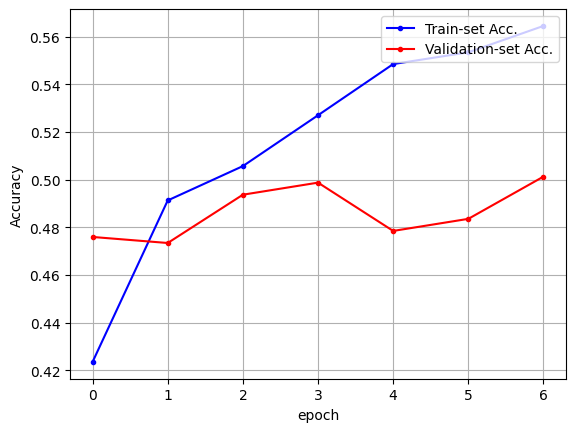

In [44]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

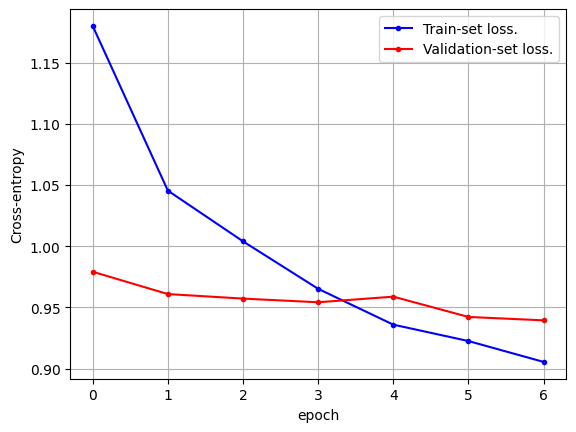

In [45]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

# 테스트 데이터 평가하기

In [46]:
test['label_encoded'] = label_encoder.transform(test['hate'])

In [47]:
# 전처리된 열과 사용빈도를 확인하기
test_cleaned_list = morphs_cleaning(test['comments'])

In [ ]:
test_cleaned_list

In [49]:
test_input_sequences = tokenizer.texts_to_sequences(test_cleaned_list)

# 패딩을 사용하여 시퀀스의 길이를 맞춤
test_padded_sequences = pad_sequences(test_input_sequences, maxlen=max_len, padding='post')

In [50]:
test_padded_sequences.shape

(471, 72)

In [51]:
result = model.evaluate(test_padded_sequences, test['label_encoded'])
print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

15/15 [==============================] - 0s 8ms/step - loss: 1.0065 - accuracy: 0.4692
loss (cross-entropy) : 1.0065220594406128
test accuracy : 0.46921443939208984


임베딩 , 데이터의 처리가 중요

데이터 정보 압축

데이터 EDA로 좀 더 태스크에 맞게 하기?

# 정확도 계산하는 다른 방법

In [52]:
y_pred = model.predict(test_padded_sequences, batch_size=1024)
test_pred_argmax = y_pred.argmax(axis=-1)
accuracy = accuracy_score(test_pred_argmax, test['label_encoded'])
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 0s 122ms/step
Accuracy: 0.4692144373673036


# 디코딩하여 정답 데이터 저장

In [53]:
y_pred = model.predict(test_padded_sequences, batch_size=1024)
test_pred_argmax = y_pred.argmax(axis=-1)
decoded_predicted_labels = label_encoder.inverse_transform(test_pred_argmax)
pd.DataFrame({'Predicted_hate':decoded_predicted_labels}).to_csv('submission.csv', index=False)

1/1 [==============================] - 0s 81ms/step
